In [1]:
###################################################################################################
#
# Copyright (C) 2023-2024 Analog Devices, Inc. All Rights Reserved.
#
# Analog Devices, Inc. Default Copyright Notice:
# https://www.analog.com/en/about-adi/legal-and-risk-oversight/intellectual-property/copyright-notice.html
#
###################################################################################################
#
# Copyright (C) 2022-2023 Maxim Integrated Products, Inc. All Rights Reserved.
#
# Maxim Integrated Products, Inc. Default Copyright Notice:
# https://www.maximintegrated.com/en/aboutus/legal/copyrights.html
#
###################################################################################################

import os
import sys

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

import torchnet.meter as tnt
from collections import OrderedDict
import importlib
from torchvision import transforms

sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', 'models'))
sys.path.append(os.path.join(os.getcwd(), '..', 'datasets'))

from types import SimpleNamespace

import ai8x

import msnoise

from signalmixer import signalmixer
import signalmixer
import kws20
from IPython.display import clear_output
from scipy.io.wavfile import write
import IPython

## Step 1: Initialize and load the model

In [21]:
#trained_checkpoint_path = os.path.join('/home/merveeyuboglu/Github/ai8x-training/logs/signalmixer_all/qat_best.pth.tar') #signalmixer_all
#trained_checkpoint_path = os.path.join('/home/merveeyuboglu/Github/ai8x-training/logs/signalmixer_all_100/2024.02.06-154139/qat_best.pth.tar') #signalmixer_all_100
#trained_checkpoint_path = os.path.join('/home/merveeyuboglu/Github/ai8x-training/logs/signalmixer_all_snr/2024.02.06-154621/qat_best.pth.tar') #signalmixer_all_snr
#trained_checkpoint_path = os.path.join('/home/merveeyuboglu/Github/ai8x-training/logs/signalmixer_babble/qat_best.pth.tar') #signalmixer_babble
#trained_checkpoint_path = os.path.join('/home/merveeyuboglu/Github/ai8x-training/logs/signalmixer_mixed/qat_best.pth.tar') #signalmixer_mixed
#trained_checkpoint_path = os.path.join('/home/merveeyuboglu/Github/ai8x-training/logs/signalmixer_vacuum/2024.02.06-215602/qat_best.pth.tar') #signalmixer_vacuum
#trained_checkpoint_path = os.path.join('..', '..', 'ai8x-synthesis', 'trained', 'ai85-kws20_nas-qat8.pth.tar')
#trained_checkpoint_path = os.path.join('/home/merveeyuboglu/Github/ai8x-training/logs/signalmixer_kws_updated/2024.02.09-154310/qat_best.pth.tar')
#trained_checkpoint_path = os.path.join('/home/merveeyuboglu/Github/ai8x-training/logs/Trained_Without_WhiteNoise/2024.02.14-150849/qat_best.pth.tar')
trained_checkpoint_path = os.path.join('/home/merveeyuboglu/Github/ai8x-training/logs/Trained_With_WhiteNoise/2024.02.14-145503/qat_best.pth.tar')
mod = importlib.import_module("ai85net-kws20-nas")
model_file = "ai85net-kws20-nas"

In [22]:
dataset = importlib.import_module("kws20")

classes = ['up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one',
           'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero', 'unknown']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working with device:", device)

ai8x.set_device(device=85, simulate=False, round_avg=False)
qat_policy = {'start_epoch': 10, 'weight_bits': 8, 'bias_bits': 8}

Working with device: cuda
Configuring device: MAX78000, simulate=False.


In [23]:
model = mod.AI85KWS20NetNAS(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=True, 
                           quantize_activation=False)

In [24]:
checkpoint = torch.load(trained_checkpoint_path)

state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'):
        k = k[7:]
    new_state_dict[k] = v
checkpoint['state_dict'] = new_state_dict

ai8x.fuse_bn_layers(model)
ai8x.initiate_qat(model, qat_policy)
model.load_state_dict(checkpoint['state_dict'], strict=False)

ai8x.update_model(model)

## Step 2: Setting up the Test Set and Parameters

You need to load the KWS test set, specify a noise list, an SNR level list. 

 If you want to specify noise kinds, you should be selecting from the defined classes for MSnoise dataset.

In [6]:
sn = SimpleNamespace()
sn.truncate_testset = False
sn.act_mode_8bit = False

data_path = '/data_ssd'

_, test_dataset = kws20.KWS_20_get_datasets( (data_path, sn), load_train=False, load_test=True)

originals = list(range(0, len(test_dataset), 3))
test_dataset.data = test_dataset.data[originals]
test_dataset.targets = test_dataset.targets[originals]


Processing test...
test set: 11005 elements
Class up (# 31): 425 elements
Class down (# 5): 406 elements
Class left (# 15): 412 elements
Class right (# 23): 396 elements
Class stop (# 27): 411 elements
Class go (# 11): 402 elements
Class yes (# 34): 419 elements
Class no (# 19): 405 elements
Class on (# 21): 396 elements
Class off (# 20): 402 elements
Class one (# 22): 399 elements
Class two (# 30): 424 elements
Class three (# 28): 405 elements
Class four (# 10): 400 elements
Class five (# 7): 445 elements
Class six (# 26): 394 elements
Class seven (# 24): 406 elements
Class eight (# 6): 408 elements
Class nine (# 18): 408 elements
Class zero (# 35): 418 elements
Class UNKNOWN: 2824 elements


Noise_list and snr_list can be changed as wanted.

In [7]:
noise_list = ['AirConditioner',
            'AirportAnnouncements',
            'Babble',
            'CopyMachine',
            'Munching',
            'NeighborSpeaking',
            'ShuttingDoor',
            'Typing',
            'VacuumCleaner',
            'TradeShow',
            'WhiteNoise']

In [8]:
snr_list = range(-5, 31, 5)

## Step 3: Functions to Evaluate Different SNR Levels

Using the evaluate, snr_testing and benchmark functions, you can test different SNR levels on your trained models evaluation. You can change the parameters above and test the wanted parameters using these functions.

In [28]:
def calculate_snr_num(snr_list):
    snr_num = len(snr_list)
    return snr_num

- Evaluate function takes the specified SNR level and Noise kind and apply it to the KWS test set.
- Snr_testing function takes the SNR list and specified noise kind and uses evaluate function to make evaluation on the KWS test set.
- Benchmark function takes SNR List and Noise Kind list and for each noise kind, makes evaluation for each SNR level in the SNR list.

In [29]:
def evaluate(db = None, noise = False, noise_kind = None):

    if (noise == True) and (noise_kind == None):
        print('Noise kind is not specified. Noise will not be applied.')
        noise = False

    model.eval()
    model.to(device) 
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(len(classes), 5)))

    transform = transforms.Compose([
        ai8x.normalize(args=sn)
    ])
    
    if noise:
        if (noise_kind == 'WhiteNoise'):

            mixed_signals = signalmixer.signalmixer(test_dataset, snr_range = [db], noise_type = noise_kind, noise_dataset = None)
            mixed_signals_loader = torch.utils.data.DataLoader(mixed_signals, batch_size = 256)

        else:
            noise_dataset = msnoise.MSnoise(root = data_path, classes = [noise_kind], d_type = 'test', dataset_len = 11005,
                                            desired_probs = None,
                                            transform=None, quantize=False, download=False)
            mixed_signals = signalmixer.signalmixer(signal_dataset=test_dataset, snr_range=[db],
                                    noise_type=noise_kind,
                                    noise_dataset=noise_dataset)
            
            mixed_signals_loader = torch.utils.data.DataLoader(mixed_signals, batch_size = 256)
    else:
        mixed_signals_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 256)
        
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(mixed_signals_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            classerr.add(outputs, targets)

            print("Batch: [",batch_idx*256 ,"/", len(test_dataset),"]")
            acc = classerr.value()[0]
            print("Accuracy: ", acc)
            
    print("Total Accuracy: ", acc)
    return acc

In [30]:
def snr_testing(snr_list = None, noise_kind = None, noise = False):

    # raw test set evaluation
    if noise == False:
        db = None
        noise_kind = None
        accuracies = np.zeros(1)
        accuracies[0] = evaluate(db, noise, noise_kind)

    # noisy test set evaluation
    else:
        snr_num = calculate_snr_num(snr_list)
        accuracies = np.zeros(snr_num)

        for idx, db in enumerate(snr_list):
            print("Evaluating SNR levels of", db)
            accuracies[idx] = evaluate(db, noise, noise_kind)

    return accuracies

In [31]:
def benchmark(noise_list = None, snr_list = None):

    if noise_list == None:
        print('Noise kind is not specified. Noise will not be applied.')
        noise = False
        snr_list = None
    else:
        noise = True
        if snr_list == None:
            print('Using default values for SNR levels: [-5, 20] dB.')
            snr_list = range(-5, 20)

    if noise:

        snr_num = calculate_snr_num(snr_list)
        num = len(noise_list) + 1

        accuracies = np.zeros((num, snr_num))

        for idx, n in enumerate(noise_list):
            print(f'{n} Noise Evaluation')
            accuracies[idx] = snr_testing(snr_list, noise_kind = n, noise = noise)

    accuracies[-1] = snr_testing(noise = False)

    return accuracies  

In [32]:
acc = benchmark(noise_list=noise_list, snr_list=snr_list)

AirConditioner Noise Evaluation
Evaluating SNR levels of -5
Labels for test: ['AirConditioner']
Each class will be selected using the same probability!
Desired probabilities for each class: [1.0]
Batch: [ 0 / 3669 ]
Accuracy:  50.0


Batch: [ 256 / 3669 ]
Accuracy:  48.828125
Batch: [ 512 / 3669 ]
Accuracy:  46.09375
Batch: [ 768 / 3669 ]
Accuracy:  45.21484375
Batch: [ 1024 / 3669 ]
Accuracy:  45.23437500000001
Batch: [ 1280 / 3669 ]
Accuracy:  47.4609375
Batch: [ 1536 / 3669 ]
Accuracy:  46.98660714285714
Batch: [ 1792 / 3669 ]
Accuracy:  46.142578125
Batch: [ 2048 / 3669 ]
Accuracy:  47.69965277777778
Batch: [ 2304 / 3669 ]
Accuracy:  48.0859375
Batch: [ 2560 / 3669 ]
Accuracy:  48.18892045454546
Batch: [ 2816 / 3669 ]
Accuracy:  47.8515625
Batch: [ 3072 / 3669 ]
Accuracy:  47.32572115384615
Batch: [ 3328 / 3669 ]
Accuracy:  48.57700892857143
Batch: [ 3584 / 3669 ]
Accuracy:  48.43281548105751
Total Accuracy:  48.43281548105751
Evaluating SNR levels of 0
Labels for test: ['AirConditioner']
Each class will be selected using the same probability!
Desired probabilities for each class: [1.0]
Batch: [ 0 / 3669 ]
Accuracy:  69.140625
Batch: [ 256 / 3669 ]
Accuracy:  69.7265625
Batch: [ 512 / 3669 ]
Accuracy:  69.53125

In [33]:
accuracies = [acc]

In [34]:
accs = []
#trained_model = 'All Noises [-5,10] dB - %80' #signalmixer_all
#trained_model = 'All Noises [-5,10] dB - %100 ' #signalmixer_all_100
#trained_model = 'All Noises [0,15] dB - %80 ' #signalmixer_all_snr
#trained_model = 'Babble Noise [-5,10] dB - %80' #signalmixer_babble
#trained_model = 'Mixed Noise [-5,10] dB - %80' #signalmixer_mixed
#trained_model = 'VacuumCleaner Noise [-5,10] dB - %80' #signalmixer_vacuum
#trained_model = 'Without Additional Noise' #default
#trained_model = 'Latest KWS WhiteNoise Application'
#trained_model = 'Trained_Without_WhiteNoise'
trained_model = 'Trained_With_WhiteNoise'
for model_name, model_acc in enumerate(accuracies):
    csv = {}

    for idx, i in enumerate(noise_list):
        csv[i] = model_acc[idx]
            
        csv_list = []
        csv_list.append(['raw', 'None', model_acc[-1][0]])

        for i in csv.keys():
            for idx, j in enumerate(csv[i]):
                csv_list.append([i, snr_list[idx], j])

        df = pd.DataFrame(csv_list, columns = ['Type', 'SNR (dB)', f'{trained_model}'])
        
    accs.append(df)

for i in accs:
    df[i.columns[-1]] = i[i.columns[-1]]

In [35]:
df

,Type,SNR (dB),Trained_With_WhiteNoise
0,raw,None,93.840283
1,AirConditioner,-5,48.432815
2,AirConditioner,0,71.872445
3,AirConditioner,5,83.864813
4,AirConditioner,10,89.234124
...,...,...,...
84,WhiteNoise,10,91.768874
85,WhiteNoise,15,92.532025
86,WhiteNoise,20,93.267920
87,WhiteNoise,25,93.731262


In [36]:
if os.path.exists('/home/merveeyuboglu/Github/ai8x-training/notebooks/KWS_comparison.csv'):
    current = pd.read_csv('KWS_comparison.csv', decimal=',', sep=';')
    current[trained_model] = list(df[trained_model].values)
    current.to_csv('KWS_comparison.csv', sep=';', decimal=',', index=False)
else:
    df.to_csv('KWS_comparison.csv', sep=';', decimal=',', index=False)

## Step 4: Noise Kind Comparison Plots

You can create data frames to examine the results of evaluation. Using the data frame, you can create plots to compare noise kinds for each model.

In [2]:
df = pd.read_csv('KWS_comparison.csv', decimal=',', sep=';')

In [3]:
df

,Type,SNR (dB),"All Noises [-5,10] dB - %80","All Noises [-5,10] dB - %100","All Noises [0,15] dB - %80","Babble Noise [-5,10] dB - %80","Mixed Noise [-5,10] dB - %80","VacuumCleaner Noise [-5,10] dB - %80",Without Additional Noise,Latest KWS WhiteNoise Application,Trained_Without_WhiteNoise,Trained_With_WhiteNoise
0,raw,NaN,93.458708,92.613791,94.031071,92.968111,93.295176,92.831834,93.894794,93.867539,93.840283,93.840283
1,AirConditioner,-5.0,75.824475,75.006814,71.899700,69.937313,72.581085,64.677024,48.351049,77.296266,48.296539,48.432815
2,AirConditioner,0.0,86.535841,85.445626,84.627964,83.319706,84.927773,79.721995,70.400654,86.045244,72.989916,71.872445
3,AirConditioner,5.0,90.787681,89.833742,90.269828,88.607250,89.970019,87.707822,83.592259,90.787681,85.336604,83.864813
4,AirConditioner,10.0,92.259471,91.632597,92.695557,91.687108,91.768874,90.215318,89.097847,93.022622,90.351594,89.234124
...,...,...,...,...,...,...,...,...,...,...,...,...
84,WhiteNoise,10.0,92.450259,90.133551,91.714364,89.997274,91.441810,91.114745,91.986917,92.068684,80.730444,91.768874
85,WhiteNoise,15.0,93.295176,91.850641,92.831834,91.877896,91.986917,92.286727,93.104388,92.722813,88.034887,92.532025
86,WhiteNoise,20.0,93.458708,92.123194,93.404197,92.204960,93.104388,92.395748,93.404197,93.376942,90.896702,93.267920
87,WhiteNoise,25.0,93.322431,92.477514,93.731262,92.750068,93.240665,92.859090,93.949305,93.840283,92.450259,93.731262


In [9]:
def plot_values(model_num):

    accuracies_values = {}

    for noise in noise_list:
        acc_list = []
        for idx, i in enumerate(df['Type'].values[1:]): 
            if i == noise:
                acc_list.append(df[model_num][1:][idx+1])
        accuracies_values[noise] = acc_list

    return accuracies_values

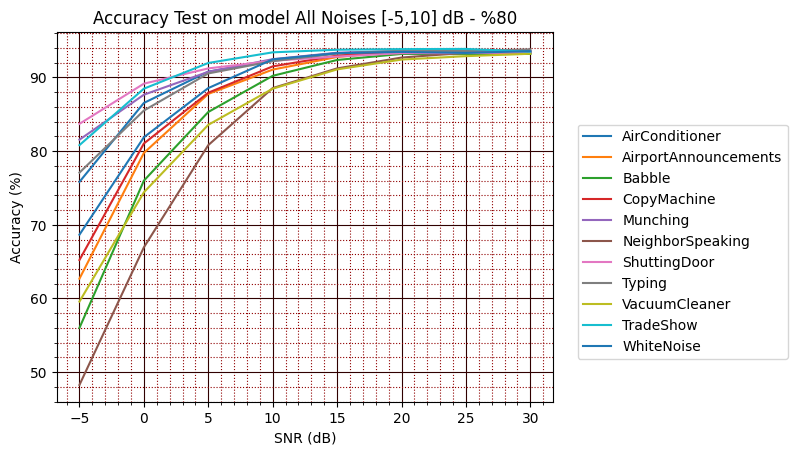

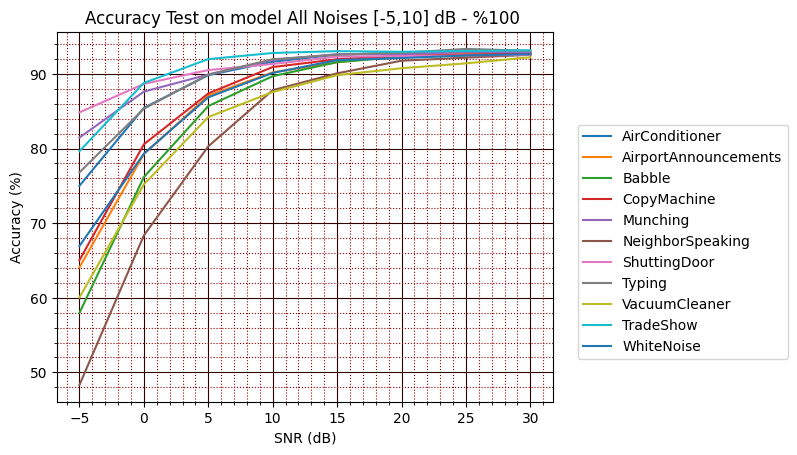

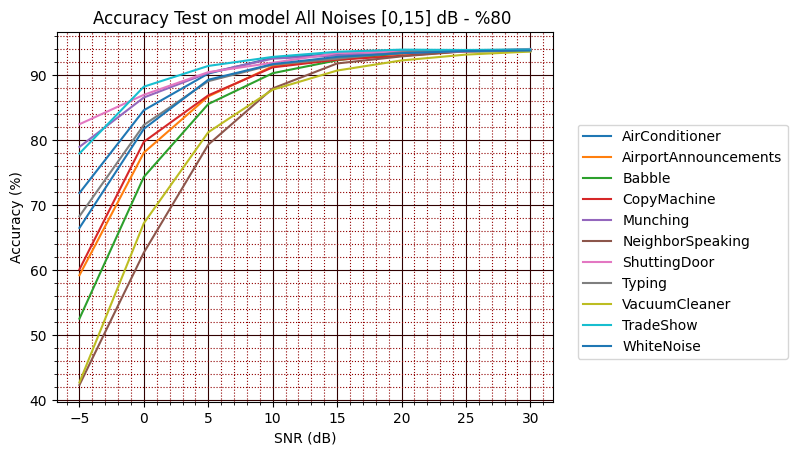

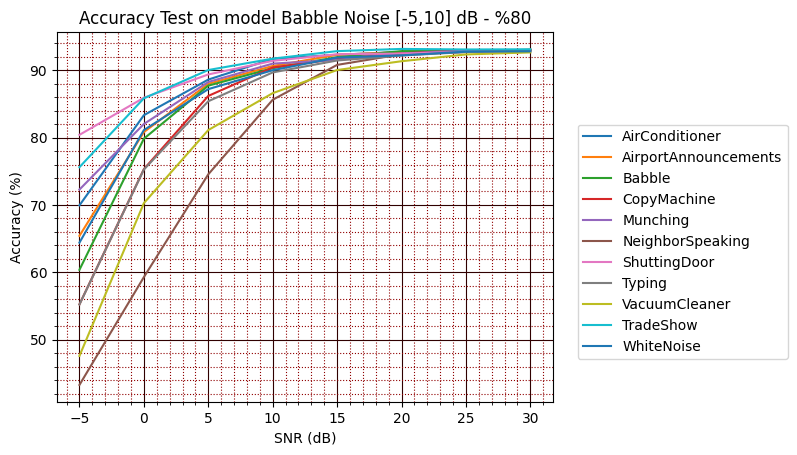

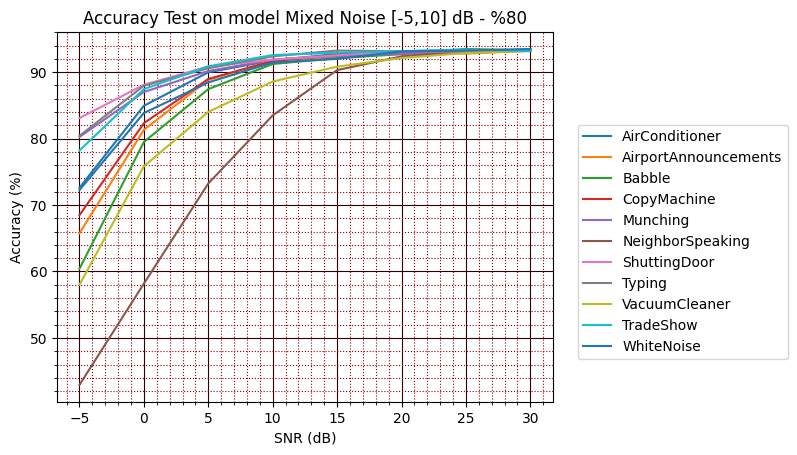

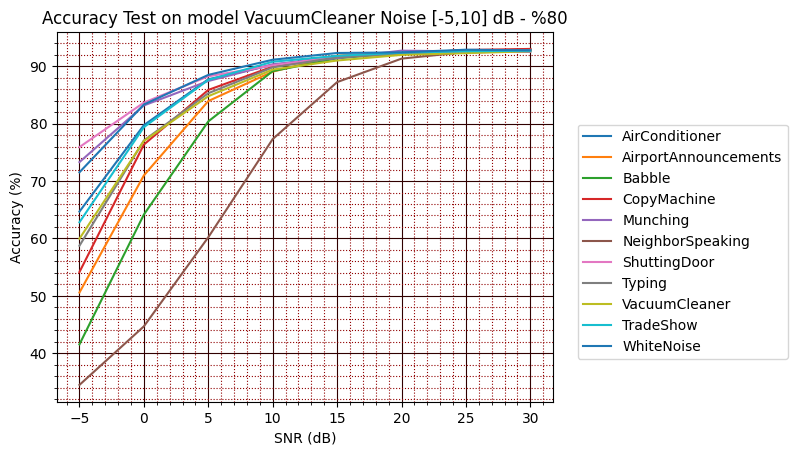

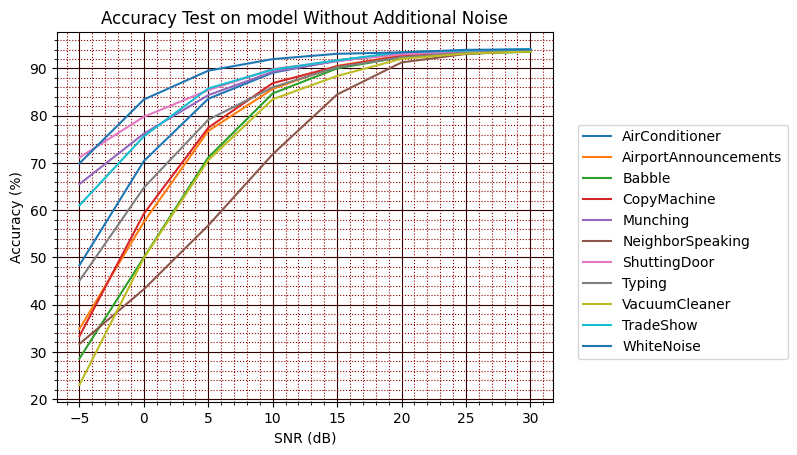

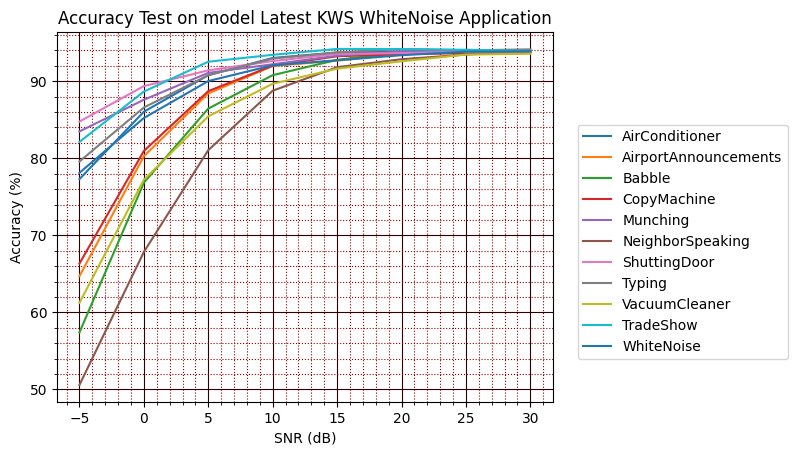

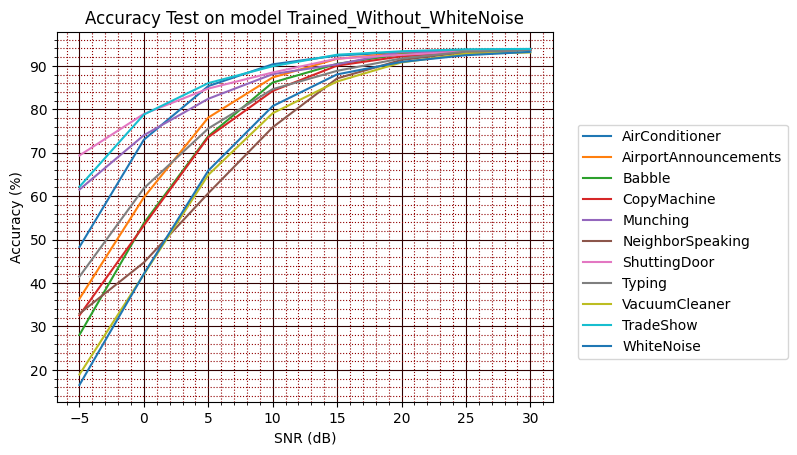

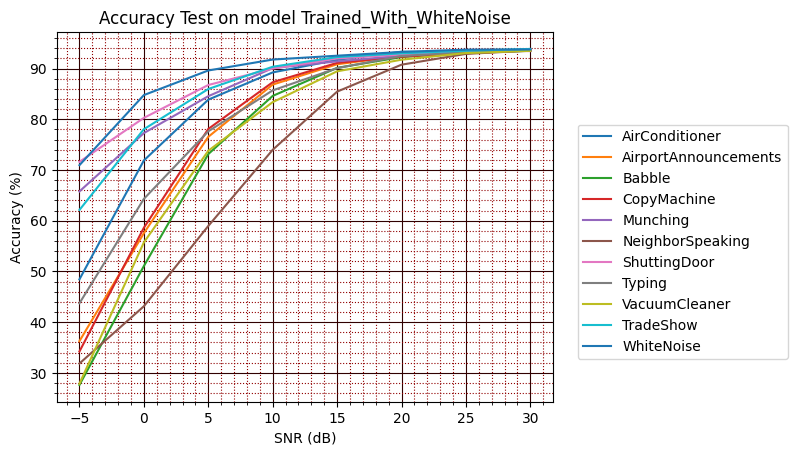

In [10]:
for model_num in df.columns[2:]:
    accuracies_values = plot_values(model_num)
    plt.figure()
    plt.grid(visible=True, which='major', color='#300000', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#900000', linestyle=':')
    for noise in noise_list:
        plt.title(f'Accuracy Test on model {model_num}')
        plt.xlabel('SNR (dB)')
        plt.ylabel('Accuracy (%)')
        plt.plot(snr_list, accuracies_values[noise])

    plt.legend(noise_list, bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)

In [11]:
new_old = {}
for model_num in df.columns[2:]:
    new_old[model_num] = plot_values(model_num)

In [12]:
new_old.keys()

dict_keys(['All Noises [-5,10] dB - %80', 'All Noises [-5,10] dB - %100 ', 'All Noises [0,15] dB - %80 ', 'Babble Noise [-5,10] dB - %80', 'Mixed Noise [-5,10] dB - %80', 'VacuumCleaner Noise [-5,10] dB - %80', 'Without Additional Noise', 'Latest KWS WhiteNoise Application', 'Trained_Without_WhiteNoise', 'Trained_With_WhiteNoise'])

## Comparison plots

### WhiteNoise Tests

Text(0, 0.5, 'Accuracies (%)')

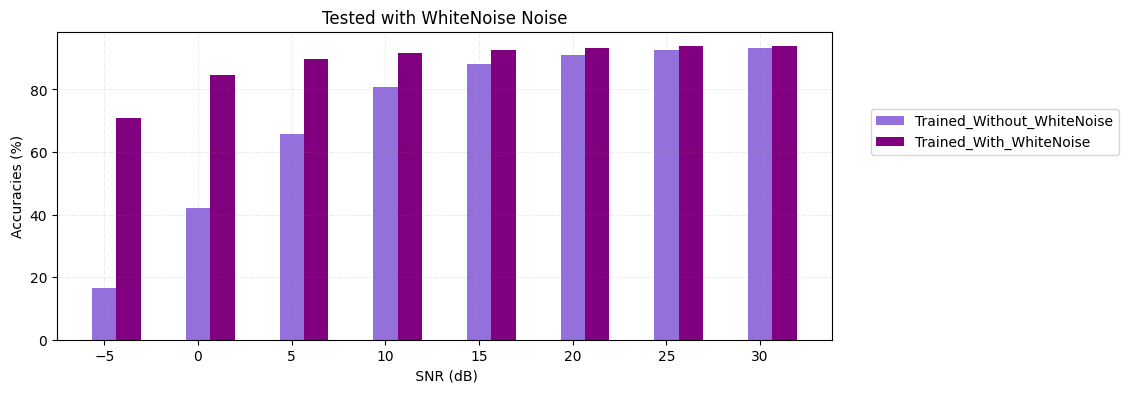

In [13]:
bar_width = 1.3
prev_snr = np.array(snr_list)
new_snr = np.array(snr_list)+bar_width
label = 'WhiteNoise'
plt.figure(figsize=(10,4))
# Plotting the data
plt.bar(prev_snr, new_old['Trained_Without_WhiteNoise'][label], width=bar_width, label='Trained_Without_WhiteNoise', color = 'mediumpurple')
plt.bar(new_snr, new_old['Trained_With_WhiteNoise'][label], width=bar_width, label='Trained_With_WhiteNoise', color = 'purple')

plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.legend(bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)
plt.title(f"Tested with {label} Noise")
plt.xlabel(' SNR (dB)')
plt.ylabel('Accuracies (%)')

Text(0, 0.5, 'Accuracies (%)')

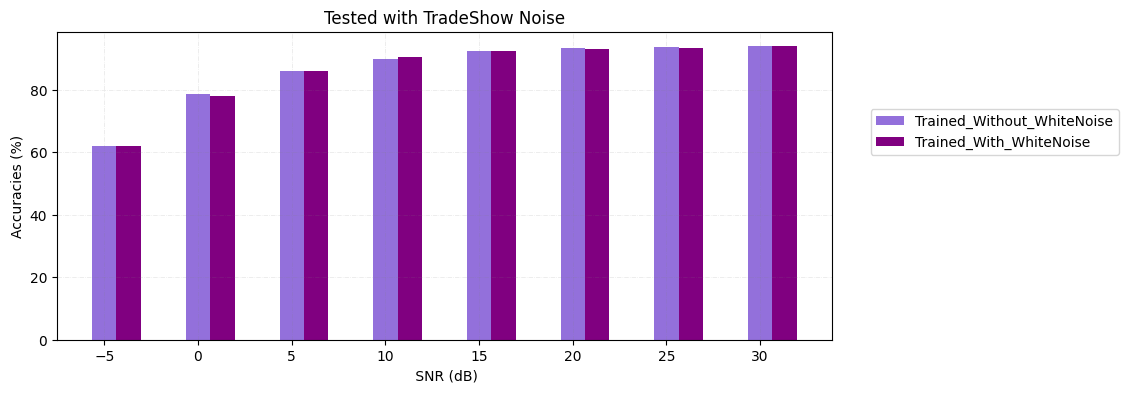

In [14]:
bar_width = 1.3
prev_snr = np.array(snr_list)
new_snr = np.array(snr_list)+bar_width
label = 'TradeShow'
plt.figure(figsize=(10,4))
# Plotting the data
plt.bar(prev_snr, new_old['Trained_Without_WhiteNoise'][label], width=bar_width, label='Trained_Without_WhiteNoise', color = 'mediumpurple')
plt.bar(new_snr, new_old['Trained_With_WhiteNoise'][label], width=bar_width, label='Trained_With_WhiteNoise', color = 'purple')

plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.legend(bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)
plt.title(f"Tested with {label} Noise")
plt.xlabel(' SNR (dB)')
plt.ylabel('Accuracies (%)')

Text(0, 0.5, 'Accuracies (%)')

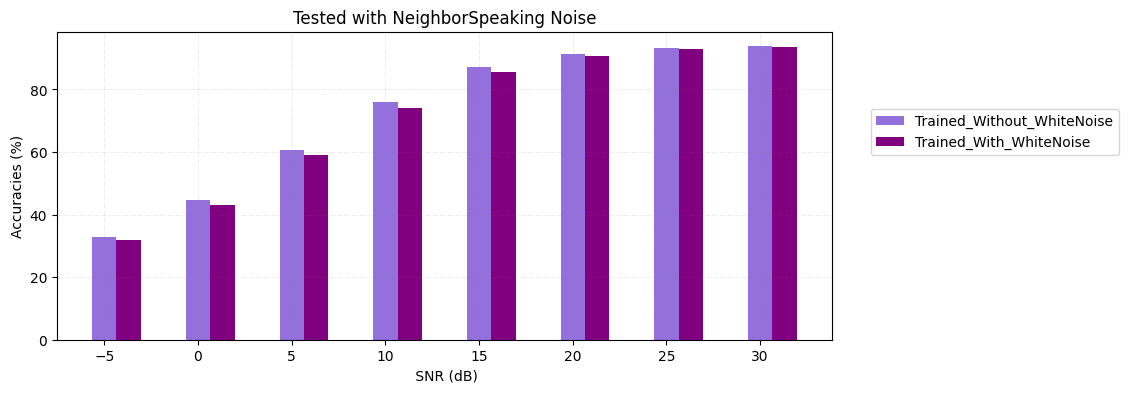

In [15]:
bar_width = 1.3
prev_snr = np.array(snr_list)
new_snr = np.array(snr_list)+bar_width
label = 'NeighborSpeaking'
plt.figure(figsize=(10,4))
# Plotting the data
plt.bar(prev_snr, new_old['Trained_Without_WhiteNoise'][label], width=bar_width, label='Trained_Without_WhiteNoise', color = 'mediumpurple')
plt.bar(new_snr, new_old['Trained_With_WhiteNoise'][label], width=bar_width, label='Trained_With_WhiteNoise', color = 'purple')

plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.legend(bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)
plt.title(f"Tested with {label} Noise")
plt.xlabel(' SNR (dB)')
plt.ylabel('Accuracies (%)')

Text(0, 0.5, 'Accuracies (%)')

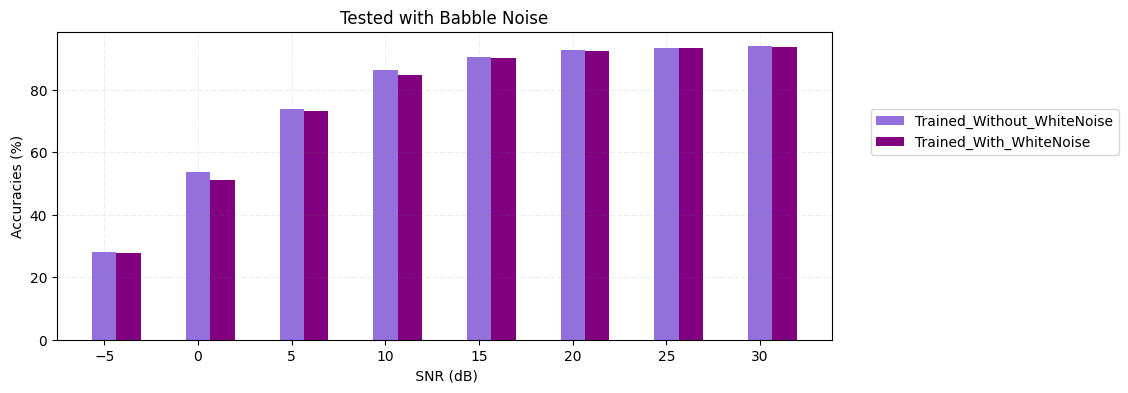

In [16]:
bar_width = 1.3
prev_snr = np.array(snr_list)
new_snr = np.array(snr_list)+bar_width
label = 'Babble'
plt.figure(figsize=(10,4))
# Plotting the data
plt.bar(prev_snr, new_old['Trained_Without_WhiteNoise'][label], width=bar_width, label='Trained_Without_WhiteNoise', color = 'mediumpurple')
plt.bar(new_snr, new_old['Trained_With_WhiteNoise'][label], width=bar_width, label='Trained_With_WhiteNoise', color = 'purple')

plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.legend(bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)
plt.title(f"Tested with {label} Noise")
plt.xlabel(' SNR (dB)')
plt.ylabel('Accuracies (%)')

Text(0, 0.5, 'Accuracies (%)')

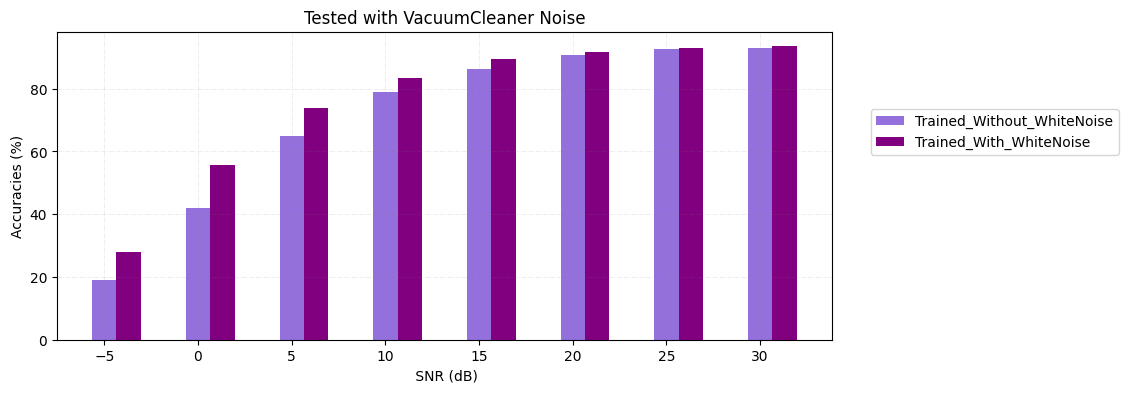

In [17]:
bar_width = 1.3
prev_snr = np.array(snr_list)
new_snr = np.array(snr_list)+bar_width
label = 'VacuumCleaner'
plt.figure(figsize=(10,4))
# Plotting the data
plt.bar(prev_snr, new_old['Trained_Without_WhiteNoise'][label], width=bar_width, label='Trained_Without_WhiteNoise', color = 'mediumpurple')
plt.bar(new_snr, new_old['Trained_With_WhiteNoise'][label], width=bar_width, label='Trained_With_WhiteNoise', color = 'purple')

plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.legend(bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)
plt.title(f"Tested with {label} Noise")
plt.xlabel(' SNR (dB)')
plt.ylabel('Accuracies (%)')

Text(0, 0.5, 'Accuracies (%)')

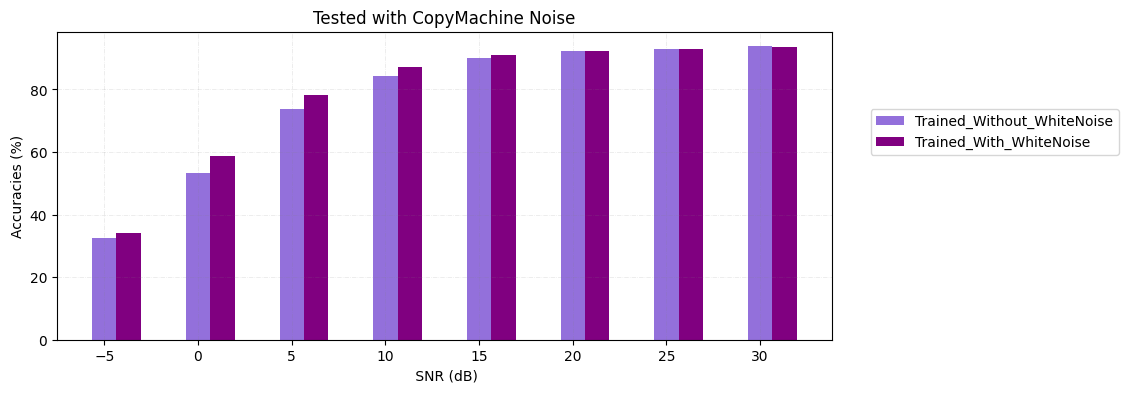

In [19]:
bar_width = 1.3
prev_snr = np.array(snr_list)
new_snr = np.array(snr_list)+bar_width
label = 'CopyMachine'
plt.figure(figsize=(10,4))
# Plotting the data
plt.bar(prev_snr, new_old['Trained_Without_WhiteNoise'][label], width=bar_width, label='Trained_Without_WhiteNoise', color = 'mediumpurple')
plt.bar(new_snr, new_old['Trained_With_WhiteNoise'][label], width=bar_width, label='Trained_With_WhiteNoise', color = 'purple')

plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.legend(bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)
plt.title(f"Tested with {label} Noise")
plt.xlabel(' SNR (dB)')
plt.ylabel('Accuracies (%)')

### Latest KWS WhiteNoise Application Results

Text(0, 0.5, 'Accuracies (%)')

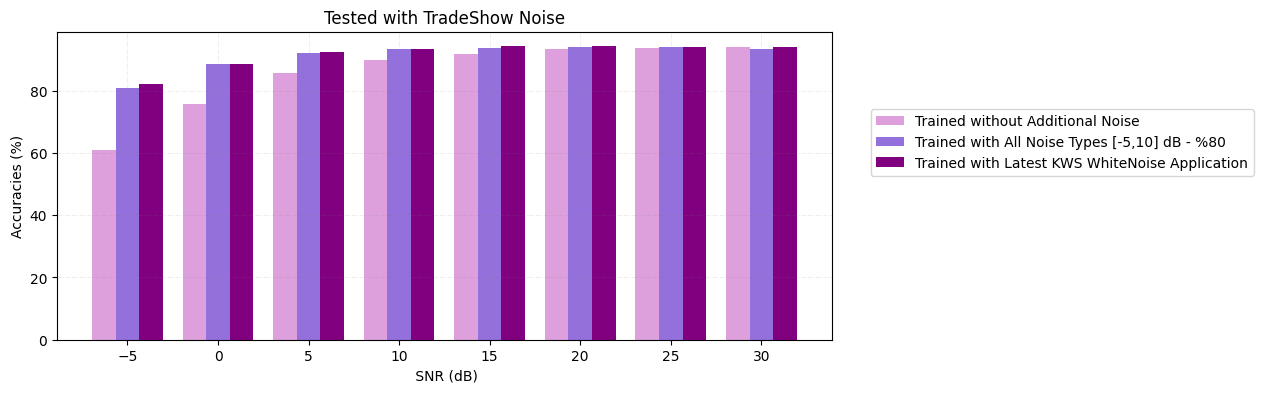

In [35]:
bar_width = 1.3
prev_snr = np.array(snr_list)
new_snr = np.array(snr_list)+bar_width
label = 'TradeShow'
plt.figure(figsize=(10,4))
# Plotting the data
plt.bar(prev_snr-bar_width, new_old['Without Additional Noise'][label], width=bar_width, label='Trained without Additional Noise', color = 'plum')
plt.bar(prev_snr, new_old['All Noises [-5,10] dB - %80'][label], width=bar_width, label='Trained with All Noise Types [-5,10] dB - %80', color = 'mediumpurple')
plt.bar(new_snr, new_old['Latest KWS WhiteNoise Application'][label], width=bar_width, label='Trained with Latest KWS WhiteNoise Application', color = 'purple')

plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.legend(bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)
plt.title(f"Tested with {label} Noise")
plt.xlabel(' SNR (dB)')
plt.ylabel('Accuracies (%)')

Text(0, 0.5, 'Accuracies (%)')

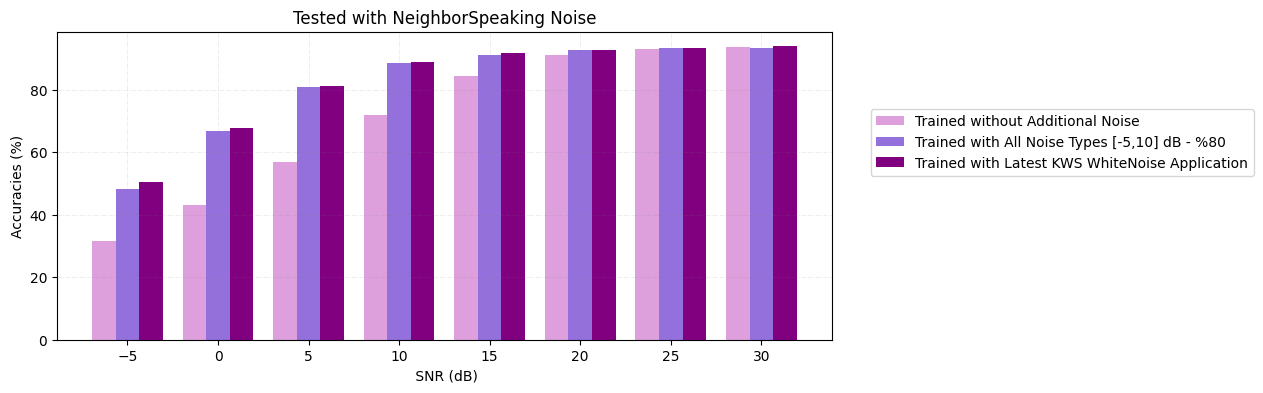

In [36]:
bar_width = 1.3
prev_snr = np.array(snr_list)
new_snr = np.array(snr_list)+bar_width
label = 'NeighborSpeaking'
plt.figure(figsize=(10,4))
# Plotting the data
plt.bar(prev_snr-bar_width, new_old['Without Additional Noise'][label], width=bar_width, label='Trained without Additional Noise', color = 'plum')
plt.bar(prev_snr, new_old['All Noises [-5,10] dB - %80'][label], width=bar_width, label='Trained with All Noise Types [-5,10] dB - %80', color = 'mediumpurple')
plt.bar(new_snr, new_old['Latest KWS WhiteNoise Application'][label], width=bar_width, label='Trained with Latest KWS WhiteNoise Application', color = 'purple')

plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.legend(bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)
plt.title(f"Tested with {label} Noise")
plt.xlabel(' SNR (dB)')
plt.ylabel('Accuracies (%)')

Text(0, 0.5, 'Accuracies (%)')

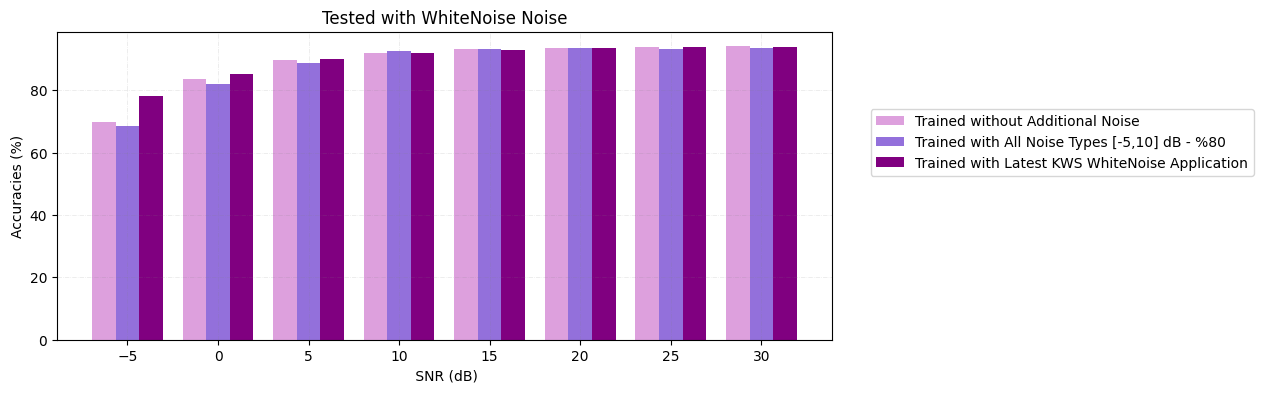

In [37]:
bar_width = 1.3
prev_snr = np.array(snr_list)
new_snr = np.array(snr_list)+bar_width
label = 'WhiteNoise'
plt.figure(figsize=(10,4))
# Plotting the data
plt.bar(prev_snr-bar_width, new_old['Without Additional Noise'][label], width=bar_width, label='Trained without Additional Noise', color = 'plum')
plt.bar(prev_snr, new_old['All Noises [-5,10] dB - %80'][label], width=bar_width, label='Trained with All Noise Types [-5,10] dB - %80', color = 'mediumpurple')
plt.bar(new_snr, new_old['Latest KWS WhiteNoise Application'][label], width=bar_width, label='Trained with Latest KWS WhiteNoise Application', color = 'purple')

plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.legend(bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)
plt.title(f"Tested with {label} Noise")
plt.xlabel(' SNR (dB)')
plt.ylabel('Accuracies (%)')

(92.0, 94.5)

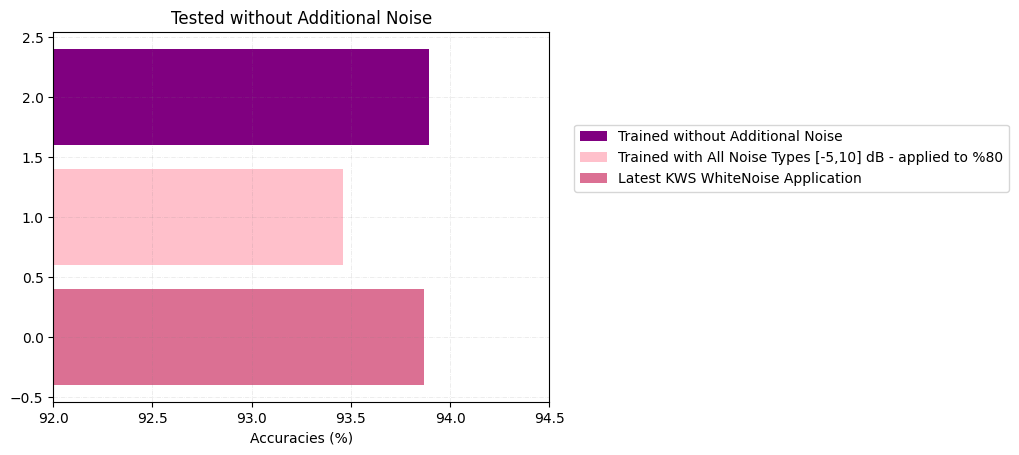

In [38]:
# Plotting the data
plt.barh(2, df['Without Additional Noise'][0], label='Trained without Additional Noise', color = 'purple')
plt.barh(1, df['All Noises [-5,10] dB - %80'][0], label='Trained with All Noise Types [-5,10] dB - applied to %80', color = 'pink')
plt.barh(0, df['Latest KWS WhiteNoise Application'][0], label='Latest KWS WhiteNoise Application', color = 'palevioletred')

plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.legend(bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)
plt.title("Tested without Additional Noise")
plt.xlabel('Accuracies (%)')
plt.xlim(92,94.5)

### For %80 application & %100 application

Text(0, 0.5, 'Accuracies (%)')

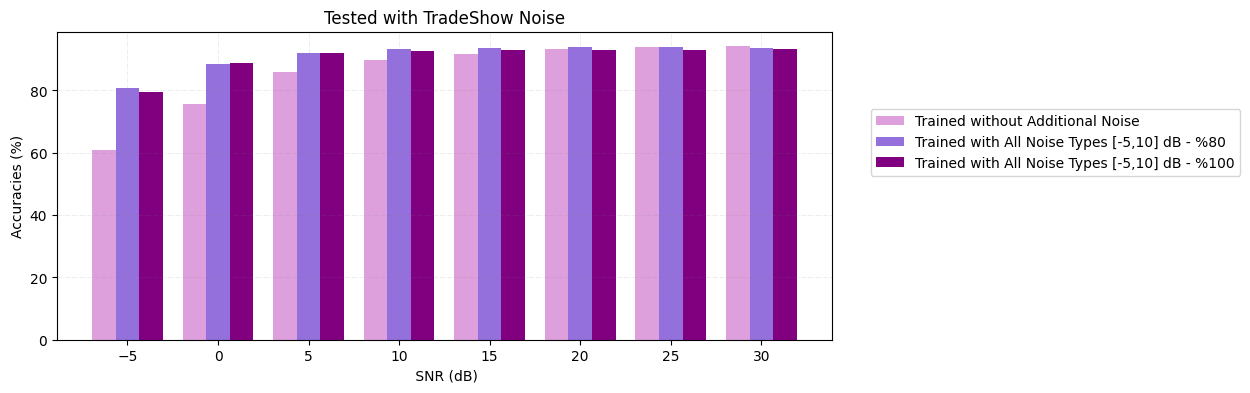

In [39]:
bar_width = 1.3
prev_snr = np.array(snr_list)
new_snr = np.array(snr_list)+bar_width
label = 'TradeShow'
plt.figure(figsize=(10,4))
# Plotting the data
plt.bar(prev_snr-bar_width, new_old['Without Additional Noise'][label], width=bar_width, label='Trained without Additional Noise', color = 'plum')
plt.bar(prev_snr, new_old['All Noises [-5,10] dB - %80'][label], width=bar_width, label='Trained with All Noise Types [-5,10] dB - %80', color = 'mediumpurple')
plt.bar(new_snr, new_old['All Noises [-5,10] dB - %100 '][label], width=bar_width, label='Trained with All Noise Types [-5,10] dB - %100', color = 'purple')

plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.legend(bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)
plt.title(f"Tested with {label} Noise")
plt.xlabel(' SNR (dB)')
plt.ylabel('Accuracies (%)')

Text(0, 0.5, 'Accuracies (%)')

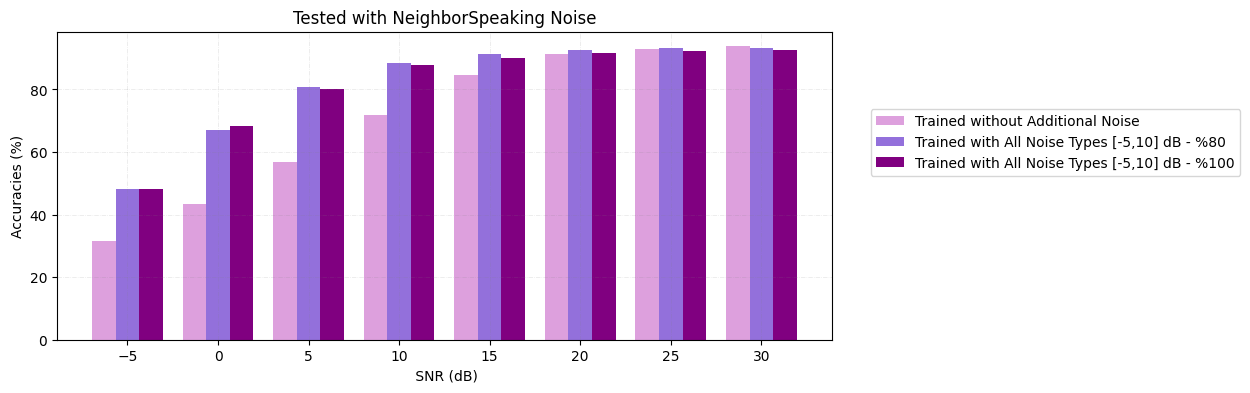

In [40]:
bar_width = 1.3
prev_snr = np.array(snr_list)
new_snr = np.array(snr_list)+bar_width
label = 'NeighborSpeaking'
plt.figure(figsize=(10,4))
# Plotting the data
plt.bar(prev_snr-bar_width, new_old['Without Additional Noise'][label], width=bar_width, label='Trained without Additional Noise', color = 'plum')
plt.bar(prev_snr, new_old['All Noises [-5,10] dB - %80'][label], width=bar_width, label='Trained with All Noise Types [-5,10] dB - %80', color = 'mediumpurple')
plt.bar(new_snr, new_old['All Noises [-5,10] dB - %100 '][label], width=bar_width, label='Trained with All Noise Types [-5,10] dB - %100', color = 'purple')

plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.legend(bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)
plt.title(f"Tested with {label} Noise")
plt.xlabel(' SNR (dB)')
plt.ylabel('Accuracies (%)')

### For different SNR ranges

Text(0, 0.5, 'Accuracies (%)')

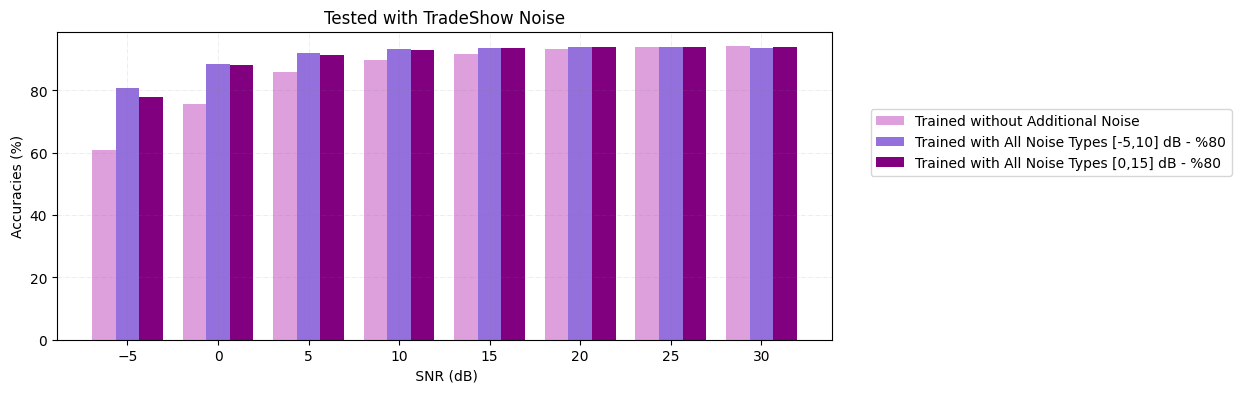

In [41]:
bar_width = 1.3
prev_snr = np.array(snr_list)
new_snr = np.array(snr_list)+bar_width
label = 'TradeShow'
plt.figure(figsize=(10,4))
# Plotting the data
plt.bar(prev_snr-bar_width, new_old['Without Additional Noise'][label], width=bar_width, label='Trained without Additional Noise', color = 'plum')
plt.bar(prev_snr, new_old['All Noises [-5,10] dB - %80'][label], width=bar_width, label='Trained with All Noise Types [-5,10] dB - %80', color = 'mediumpurple')
plt.bar(new_snr, new_old['All Noises [0,15] dB - %80 '][label], width=bar_width, label='Trained with All Noise Types [0,15] dB - %80', color = 'purple')

plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.legend(bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)
plt.title(f"Tested with {label} Noise")
plt.xlabel(' SNR (dB)')
plt.ylabel('Accuracies (%)')

Text(0, 0.5, 'Accuracies (%)')

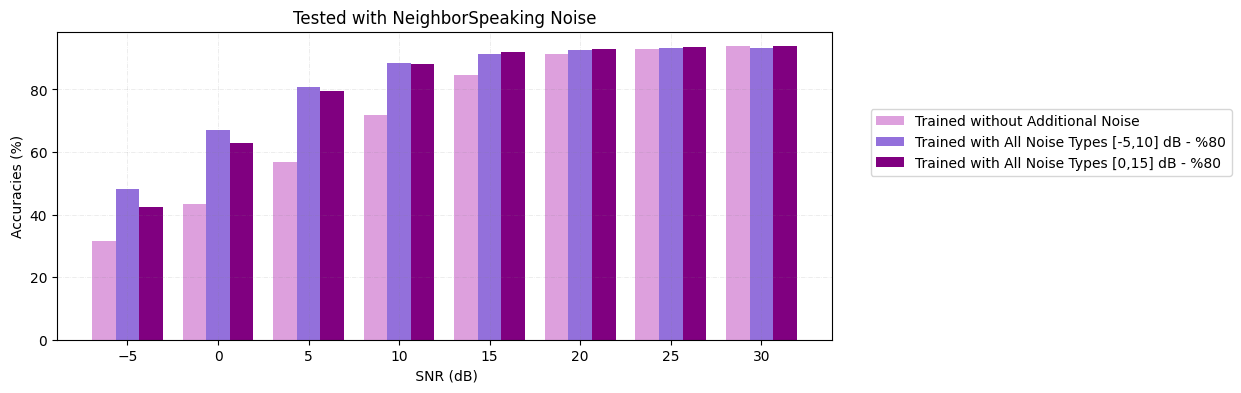

In [42]:
bar_width = 1.3
prev_snr = np.array(snr_list)
new_snr = np.array(snr_list)+bar_width
label = 'NeighborSpeaking'
plt.figure(figsize=(10,4))
# Plotting the data
plt.bar(prev_snr-bar_width, new_old['Without Additional Noise'][label], width=bar_width, label='Trained without Additional Noise', color = 'plum')
plt.bar(prev_snr, new_old['All Noises [-5,10] dB - %80'][label], width=bar_width, label='Trained with All Noise Types [-5,10] dB - %80', color = 'mediumpurple')
plt.bar(new_snr, new_old['All Noises [0,15] dB - %80 '][label], width=bar_width, label='Trained with All Noise Types [0,15] dB - %80', color = 'purple')

plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.legend(bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)
plt.title(f"Tested with {label} Noise")
plt.xlabel(' SNR (dB)')
plt.ylabel('Accuracies (%)')

### For testing raw data without additional noise

([0, 1, 2, 3],
 [Text(0, 0, 'Trained without Additional Noise'),
  Text(1, 0, 'Trained with All Noise Types [-5,10] dB - applied to %100'),
  Text(2, 0, 'Trained with All Noise Types [-5,10] dB - applied to %80'),
  Text(3, 0, 'Trained with All Noise Types [0,15] dB - applied to %80')])

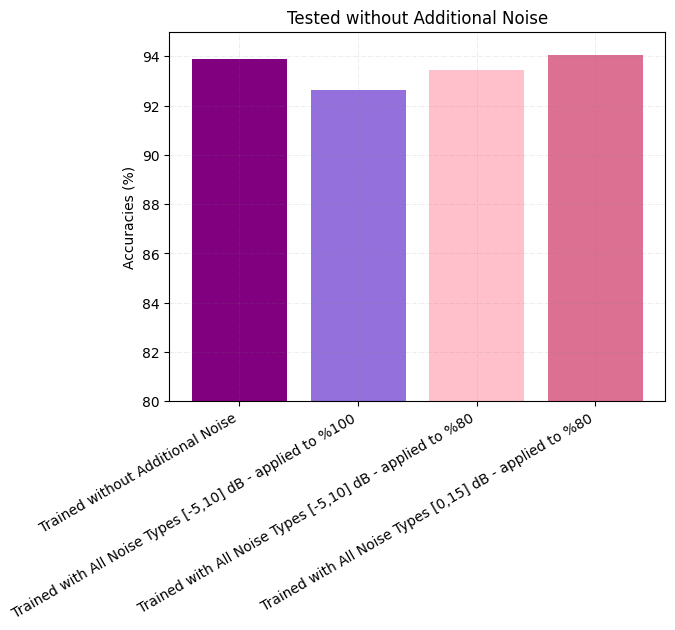

In [68]:
# Plotting the data
plt.bar('Trained without Additional Noise', df['Without Additional Noise'][0], color = 'purple')
plt.bar('Trained with All Noise Types [-5,10] dB - applied to %100', df['All Noises [-5,10] dB - %100 '][0], color = 'mediumpurple')
plt.bar('Trained with All Noise Types [-5,10] dB - applied to %80', df['All Noises [-5,10] dB - %80'][0], color = 'pink')
plt.bar('Trained with All Noise Types [0,15] dB - applied to %80', df['All Noises [0,15] dB - %80 '][0], color = 'palevioletred')

plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.title("Tested without Additional Noise")
plt.ylabel('Accuracies (%)')
plt.ylim(80,95)
plt.xticks(rotation=30, ha = 'right')

## Tests

In [27]:
sn = SimpleNamespace()
sn.truncate_testset = False
sn.act_mode_8bit = False

data_path = '/data_ssd'
train_dataset, _ = kws20.KWS_20_get_datasets((data_path,sn), load_train=True, load_test=False)


Processing train...
train set: 316395 elements
validation set: 29943 elements
Class up (# 31): 9894 elements
Class down (# 5): 10533 elements
Class left (# 15): 10167 elements
Class right (# 23): 10146 elements
Class stop (# 27): 10383 elements
Class go (# 11): 10434 elements
Class yes (# 34): 10875 elements
Class no (# 19): 10608 elements
Class on (# 21): 10347 elements
Class off (# 20): 10029 elements
Class one (# 22): 10473 elements
Class two (# 30): 10368 elements
Class three (# 28): 9966 elements
Class four (# 10): 9984 elements
Class five (# 7): 10821 elements
Class six (# 26): 10398 elements
Class seven (# 24): 10776 elements
Class eight (# 6): 10137 elements
Class nine (# 18): 10578 elements
Class zero (# 35): 10902 elements
Class UNKNOWN: 138519 elements


In [25]:
train_dataset[10]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 20)

In [14]:
write('/home/merveeyuboglu/Github/ai8x-training/notebooks/audios/sample.wav', rate = 16000, data = np.array(train_dataset[10][0]).flatten('F'))

SNR value: 19


In [10]:
train_dataset[0][0]

SNR value: 5


tensor([[-0.0781, -0.0547, -0.0469,  ..., -0.0781, -0.1016, -0.0781],
        [-0.0703, -0.0625, -0.0547,  ..., -0.0859, -0.1016, -0.0859],
        [-0.0781, -0.0781, -0.0547,  ..., -0.0859, -0.1016, -0.0781],
        ...,
        [-0.0469, -0.0391, -0.0781,  ..., -0.1016, -0.0781, -0.0781],
        [-0.0547, -0.0469, -0.0703,  ..., -0.1016, -0.0859, -0.0781],
        [-0.0547, -0.0469, -0.0859,  ..., -0.1016, -0.0859, -0.0781]])